# Naive Bayes

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("../Data/spam.csv", encoding="latin-1") # encoding="latin-1" is used to avoid errors
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [43]:
df[df.columns[2:]].isna().sum()

df_no_na = df.dropna(axis = 1)
df_no_na.columns = ["class", "content"]
df_no_na.head()

,class,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: xlabel='class', ylabel='count'>

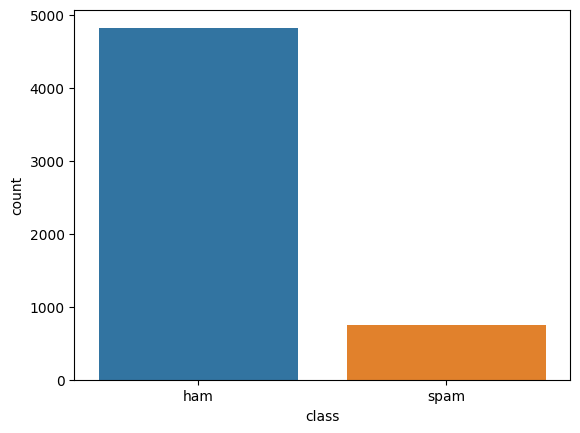

In [44]:
sns.countplot(df_no_na, x="class")

In [45]:
df = pd.get_dummies(df_no_na, columns = ["class"], drop_first=True)

X, y = df["content"], df["class_spam"]

In [46]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: class_spam, dtype: uint8

## TF-IDF
- Term Frequency - Inverse Document Frequency

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

TfidfVectorizer = TfidfVectorizer(stop_words="english") # Stop words are words that are filtered out before or after processing of natural language data (text).
# Stop words are usually the most common words in a language. So they are not very useful for text classification.




In [48]:
X_tfidf = TfidfVectorizer.fit_transform(X)
X_tfidf

<5572x8404 sparse matrix of type '<class 'numpy.float64'>'
	with 43478 stored elements in Compressed Sparse Row format>

In [49]:
X_tfidf.min(), X_tfidf.max()

(0.0, 1.0)

In [50]:
from utils import print_shapes
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=.33, random_state=42)
print_shapes(X_train, X_test, y_train, y_test)

X_train shape: (3733, 8404)
X_test shape: (1839, 8404)
y_train shape: (3733,)
y_test shape: (1839,)



<Axes: xlabel='class_spam', ylabel='count'>

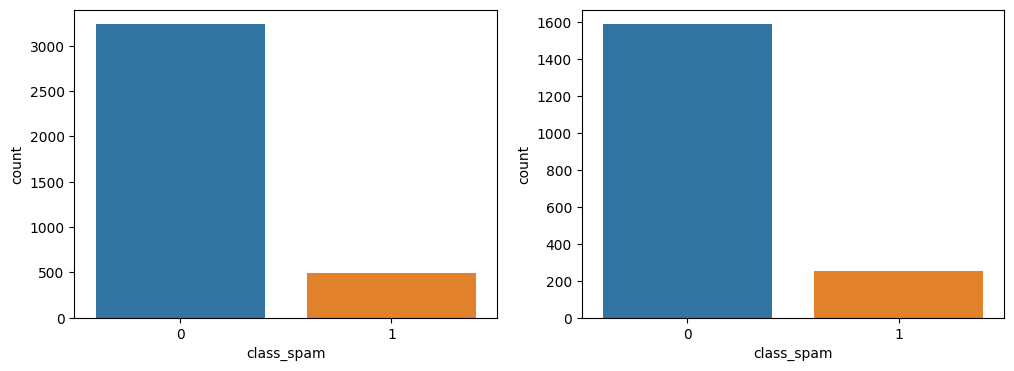

In [51]:
fig, ax = plt.subplots(1,2,figsize=(12, 4))
sns.countplot(x = y_train, ax=ax[0])
sns.countplot(x = y_test, ax=ax[1])

## Naive bayes

In [53]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

naive_bayes = dict(
    multinomial = MultinomialNB(),
    complement = ComplementNB(),
    bernoulli = BernoulliNB()
)
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels = ["Ham", "Spam"]).plot()




              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1587
           1       1.00      0.75      0.86       252

    accuracy                           0.97      1839
   macro avg       0.98      0.88      0.92      1839
weighted avg       0.97      0.97      0.96      1839



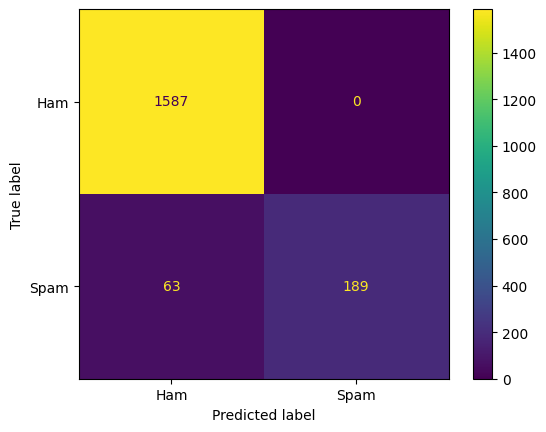

In [54]:
evaluate_model(naive_bayes["multinomial"])

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1587
           1       0.98      0.81      0.89       252

    accuracy                           0.97      1839
   macro avg       0.97      0.91      0.94      1839
weighted avg       0.97      0.97      0.97      1839



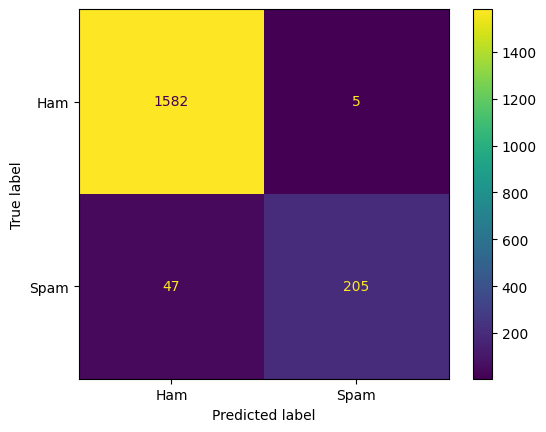

In [55]:
evaluate_model(naive_bayes["bernoulli"])

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      1587
           1       0.66      0.94      0.78       252

    accuracy                           0.93      1839
   macro avg       0.83      0.93      0.87      1839
weighted avg       0.95      0.93      0.93      1839



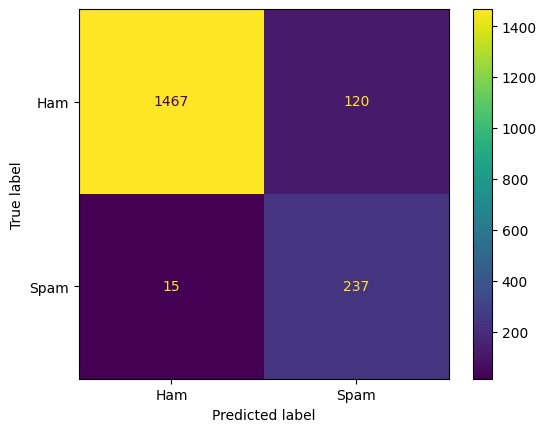

In [56]:
evaluate_model(naive_bayes["complement"])

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1587
           1       0.99      0.83      0.90       252

    accuracy                           0.98      1839
   macro avg       0.98      0.91      0.94      1839
weighted avg       0.98      0.98      0.97      1839



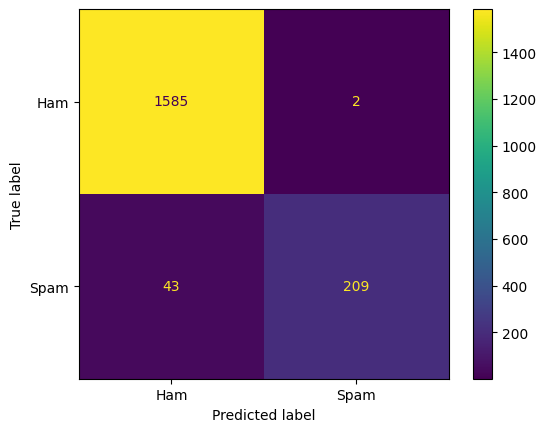

In [57]:
from sklearn.ensemble import RandomForestClassifier

evaluate_model(RandomForestClassifier())

## Combine different models

- majority vote
- class with most votes wins or (hard voting)
- class with highest probability wins (soft voting)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1587
           1       1.00      0.80      0.89       252

    accuracy                           0.97      1839
   macro avg       0.98      0.90      0.94      1839
weighted avg       0.97      0.97      0.97      1839



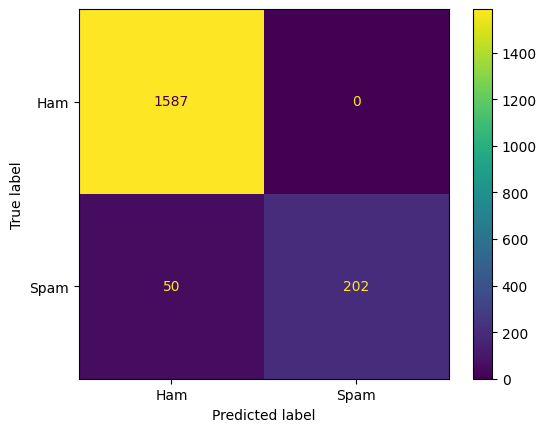

In [58]:
from sklearn.ensemble import VotingClassifier

vote_clf = VotingClassifier([
    ("random_forest", RandomForestClassifier()),
    #("svc", LinearSVC()),
    ("naive_complement", ComplementNB()),
    ("naive_multinomial", MultinomialNB() ),
    ("naive_bernoulli", BernoulliNB()),
], voting = "hard")

evaluate_model(vote_clf)

## Testing out a model
assume we choose vote_clf

In [59]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("tfidf", TfidfVectorizer(stop_words="english")), ("vote", vote_clf)])


# fits on all data
pipe.fit(X, y)
pipe.predict(["Collect Prize Money Now!"])

TypeError: 'TfidfVectorizer' object is not callable